In [19]:
import joblib
import pandas as pd
import numpy as np
import sklearn.impute as impute
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import sklearn.metrics as metrics
import matplotlib.pyplot as pl

In [20]:
def data_load(path):
    df = pd.read_csv(path)
    sample_id = df['sample_id'].values
    features = df.loc[:, 'feature0':'feature106'].values
    label = df['label'].values
    return sample_id, features, label


def data_load_test(path):
    df = pd.read_csv(path)
    sample_id = df['sample_id'].values
    features = df.loc[:, 'feature0':'feature106'].values
    return sample_id, features


def train_pre_process(X, y, threshold):
    imputer = impute.SimpleImputer(strategy="most_frequent")
    imputer.fit(X)
    X = imputer.transform(X)
    clf = ExtraTreesClassifier(n_estimators=70, n_jobs=-1, random_state=42)
    clf = clf.fit(X, y)
    selection_model = SelectFromModel(clf, prefit=True, threshold=threshold)
    X = selection_model.transform(X)
    print('test selected features:' + str(X.shape))
    return X, y, selection_model


def valid_pre_process(X, selection_model):
    imputer = impute.SimpleImputer(strategy="most_frequent")
    imputer.fit(X)
    X = imputer.transform(X)
    X = selection_model.transform(X)
    print(X.shape)
    return X


def plot_matrix(y_true, y_pred, labels_name, title=None, thresh=0.8, axis_labels=None):
    cm = metrics.confusion_matrix(y_true, y_pred, labels=labels_name, sample_weight=None)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    pl.imshow(cm, interpolation='nearest', cmap=pl.get_cmap('Blues'))
    pl.colorbar()

    if title is not None:
        pl.title(title)
    num_local = np.array(range(len(labels_name)))
    if axis_labels is None:
        axis_labels = labels_name
    pl.xticks(num_local, axis_labels)
    pl.yticks(num_local, axis_labels)
    pl.ylabel('True label')
    pl.xlabel('Predicted label')

    for i in range(np.shape(cm)[0]):
        for j in range(np.shape(cm)[1]):
            if int(cm[i][j] * 100 + 0.5) > 0:
                pl.text(j, i, format(int(cm[i][j] * 100 + 0.5), 'd') + '%',
                        ha="center", va="center",
                        color="white" if cm[i][j] > thresh else "black")
    pl.show()


In [21]:
def object_to_joblib(obj):
    joblib.dump(obj, "../modelfiles/model.joblib")

In [22]:
sample_id, features, label = data_load(path="../data_new/train_10000.csv")
X_train, y_train, selection_model = train_pre_process(features, label, '1.5*mean')

test selected features:(10000, 16)


In [23]:
rfc1 = RandomForestClassifier(criterion='gini',
                              max_depth=17,  # 十几层已经算深了
                              n_estimators=200,  # 影响最大的参数，估计最优在150-300间
                              max_features='sqrt',
                              min_samples_split=20,
                              class_weight='balanced',
                              random_state=42,
                              oob_score=True,
                              min_samples_leaf=10,
                              n_jobs=-1)

rfc2 = RandomForestClassifier(criterion='gini',
                              max_depth=17,  # 十几层已经算深了
                              n_estimators=200,  # 影响最大的参数，估计最优在150-300间
                              max_features='sqrt',
                              min_samples_split=20,
                              class_weight='balanced',
                              random_state=42,
                              oob_score=True,
                              min_samples_leaf=10,
                              n_jobs=-1)
rfc1.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=17,
                       min_samples_leaf=10, min_samples_split=20,
                       n_estimators=200, n_jobs=-1, oob_score=True,
                       random_state=42)

(1000, 16)
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       197
           1       0.97      0.60      0.74       270
           2       0.27      1.00      0.43        47
           3       0.98      0.98      0.98       169
           4       0.99      0.93      0.96       165
           5       0.93      0.99      0.96       152

    accuracy                           0.85      1000
   macro avg       0.85      0.89      0.83      1000
weighted avg       0.93      0.85      0.87      1000



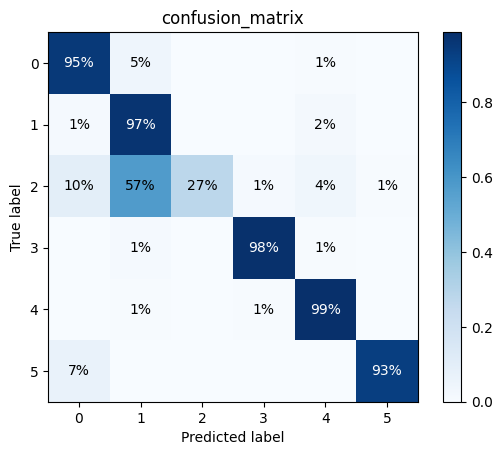

In [24]:
sample_id_v, features_v, label_v = data_load(path="../data_new/validate_1000.csv")
X_test = valid_pre_process(features_v, selection_model)
y_true = label_v

y_pred = rfc1.predict(X_test)
print(metrics.classification_report(y_pred, y_true))  # 打印报告，这种字符串需要返回给前端
plot_matrix(y_true, y_pred, [0, 1, 2, 3, 4, 5], title='confusion_matrix',
            axis_labels=['0', '1', '2', '3', '4', '5'])  # 混淆矩阵以json的方式返回给前端

test selected features:(2675, 6)
(317, 6)
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       197
           1       0.81      0.86      0.84       157
           2       0.73      0.78      0.76       160
           3       0.98      0.98      0.98       169
           4       0.99      0.93      0.96       165
           5       0.93      0.99      0.96       152

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



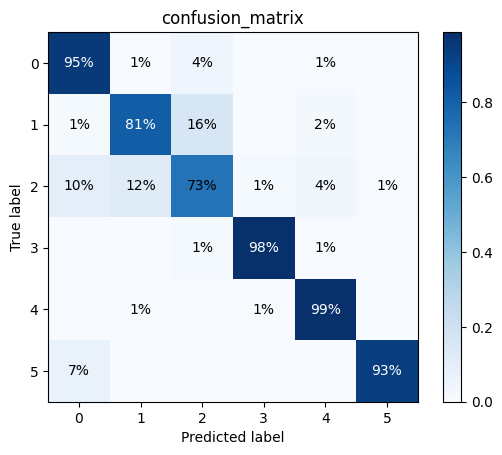

In [25]:
# 1 2训练集
category_filter_1 = np.isin(label, [1, 2])  # 过滤器
X_filtered_1 = features[category_filter_1]
y_filtered_1 = label[category_filter_1]
X_train_1, y_train_1, selection_model_1 = train_pre_process(X_filtered_1, y_filtered_1, '1.85*mean')
rfc2.fit(X_train_1, y_train_1)

# 1 2验证集
category_filter_2 = np.isin(y_pred, [1, 2])
X_filtered_2 = features_v[category_filter_2]
y1_true_1 = label_v[category_filter_2]
X_1 = valid_pre_process(X_filtered_2, selection_model_1)
y1_pred_1 = rfc2.predict(X_1)

category_filter_3 = np.isin(y_pred, [0, 3, 4, 5])
y2_pred_1 = y_pred[category_filter_3]
y2_true_1 = label_v[category_filter_3]

# 合并结果
y_pred_1 = np.concatenate((y1_pred_1, y2_pred_1))
y_true_1 = np.concatenate((y1_true_1, y2_true_1))
print(metrics.classification_report(y_pred_1, y_true_1))  # 打印报告，这种字符串需要返回给前端
plot_matrix(y_true_1, y_pred_1, [0, 1, 2, 3, 4, 5], title='confusion_matrix',
            axis_labels=['0', '1', '2', '3', '4', '5'])

object_to_joblib(rfc1)